### Import

In [12]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import random
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import f1_score

### GPU Check

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

Using device:cuda


### Data Augmentation

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [4]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

### Load Data

In [5]:
train_dataset = ImageFolder(
    root="/kaggle/input/animal-faces/afhq/train", 
    transform=train_transform
)

In [6]:
val_dataset = ImageFolder(
    root="/kaggle/input/animal-faces/afhq/val", 
    transform=val_transform
)

### Display

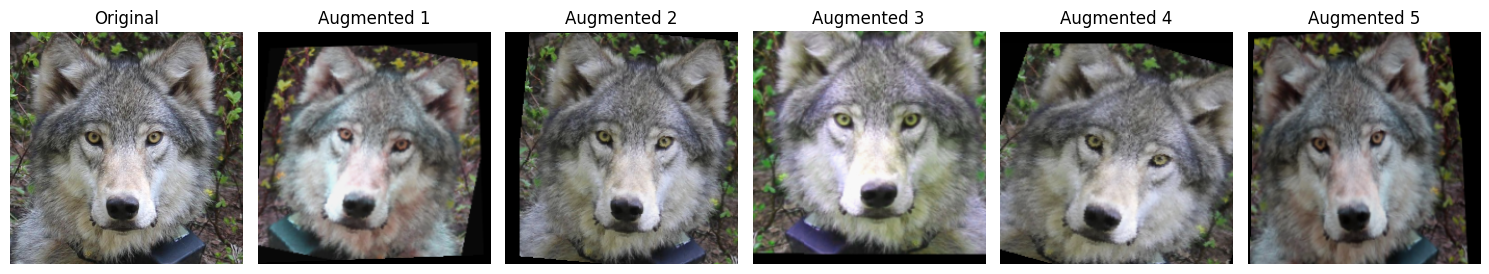

In [7]:
sample_idx = random.randint(0, len(train_dataset) - 1)
sample_image_path, _ = train_dataset.samples[sample_idx]
sample_image = Image.open(sample_image_path)

def imshow(ax, img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5
    img = np.clip(img, 0, 1)
    ax.imshow(img)

augmented_images = [train_transform(sample_image) for _ in range(5)]

fig, axes = plt.subplots(1, 6, figsize=(15, 5))

axes[0].imshow(sample_image)
axes[0].set_title("Original")
axes[0].axis("off")

for i in range(5):
    imshow(axes[i+1], augmented_images[i])
    axes[i+1].set_title(f"Augmented {i+1}")
    axes[i+1].axis("off")

plt.tight_layout()
plt.show()

### Create DataLoader

In [8]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=2
)

In [9]:
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=2
)

In [10]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch size: {images.shape}")
print(f"Labels: {labels[:10]}")

Batch size: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 0, 2, 2, 1, 0, 0, 2, 1, 2])


### Model Load

In [14]:
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 3)
)
resnet50 = resnet50.to(device)

### Freeze Layer Except Layer4 and fc

In [15]:
for name, param in resnet50.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad - False

### Optimizer, Scheduler and Loss Function

In [17]:
optimizer = optim.Adam([
    {"params": resnet50.layer4.parameters(), "lr": 1e-4},
    {"params": resnet50.fc.parameters(), "lr": 1e-3}
], weight_decay=1e-5)

In [18]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Create F1 Function

In [19]:
def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(data_loader)

    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1

### Training

In [20]:
num_epochs = 30
best_f1 = 0.0
patience = 5
trigger_times = 0

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    val_loss, val_f1 = evaluate(resnet50, val_loader)
    print(f"Validation Loss: {val_loss:.4f}, F1 Score: {val_f1:.4f}")

    scheduler.step(val_f1)

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(resnet50.state_dict(), "best_resnet50.pth")
        print("Best model saved.")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"No improvement in F1 for {trigger_times} epoch(s).")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/30, Train Loss: 0.0510
Validation Loss: 0.0142, F1 Score: 0.9953
Best model saved.
Epoch 2/30, Train Loss: 0.0188
Validation Loss: 0.0204, F1 Score: 0.9940
No improvement in F1 for 1 epoch(s).
Epoch 3/30, Train Loss: 0.0151
Validation Loss: 0.0314, F1 Score: 0.9900
No improvement in F1 for 2 epoch(s).
Epoch 4/30, Train Loss: 0.0148
Validation Loss: 0.0095, F1 Score: 0.9987
Best model saved.
Epoch 5/30, Train Loss: 0.0193
Validation Loss: 0.0232, F1 Score: 0.9953
No improvement in F1 for 1 epoch(s).
Epoch 6/30, Train Loss: 0.0200
Validation Loss: 0.0125, F1 Score: 0.9973
No improvement in F1 for 2 epoch(s).
Epoch 7/30, Train Loss: 0.0077
Validation Loss: 0.0127, F1 Score: 0.9987
No improvement in F1 for 3 epoch(s).
Epoch 8/30, Train Loss: 0.0097
Validation Loss: 0.0106, F1 Score: 0.9980
No improvement in F1 for 4 epoch(s).
Epoch 9/30, Train Loss: 0.0057
Validation Loss: 0.0077, F1 Score: 0.9980
No improvement in F1 for 5 epoch(s).
Early stopping triggered.


### Test Model

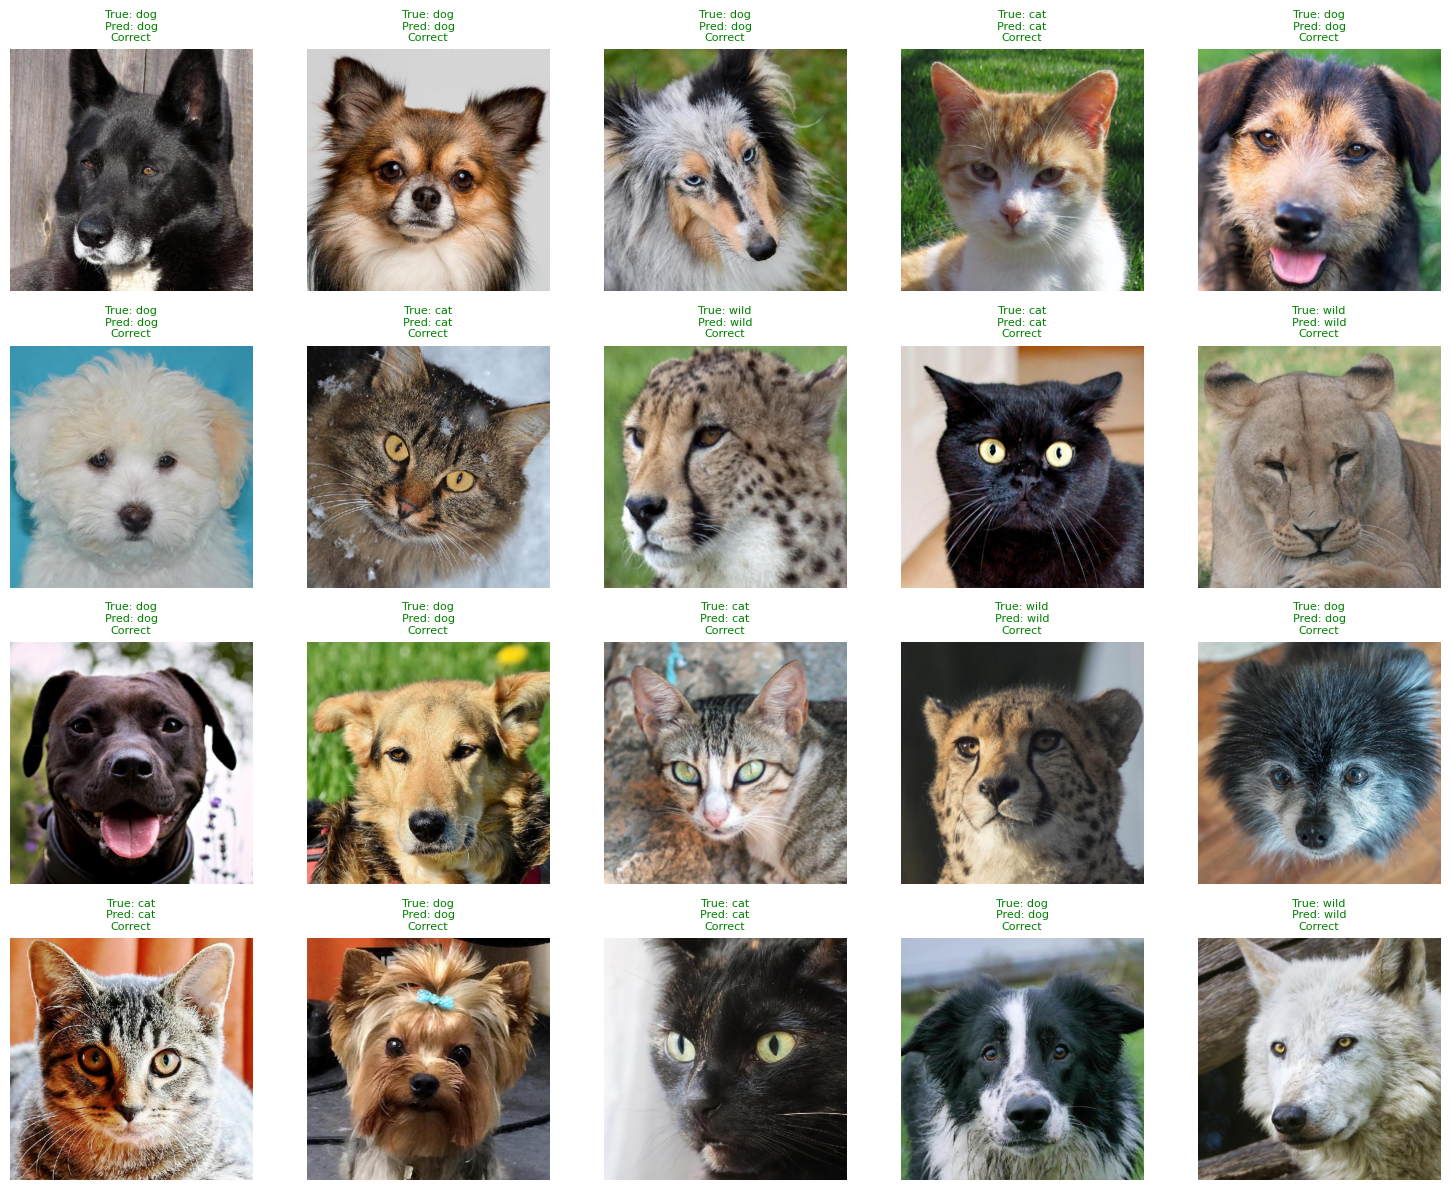

In [25]:
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

num_images = 20
sample_indices = random.sample(range(len(val_dataset)), num_images)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))

for ax, idx in zip(axes.flatten(), sample_indices):
    sample_path, true_label = val_dataset.samples[idx]
    sample_img = Image.open(sample_path)
    
    img_tensor = val_transform(sample_img).unsqueeze(0).to(device)
    
    resnet50.eval()
    with torch.no_grad():
        output = resnet50(img_tensor)
        _, pred = torch.max(output, 1)
    pred_label = pred.item()
    
    result_text = "Correct" if pred_label == true_label else "Incorrect"
    text_color = "green" if pred_label == true_label else "red"
    
    true_label_name = idx_to_class[true_label]
    pred_label_name = idx_to_class[pred_label]
    
    ax.imshow(sample_img)
    ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}\n{result_text}", 
                 fontsize=8, color=text_color)
    ax.axis("off")

plt.tight_layout()
plt.show()

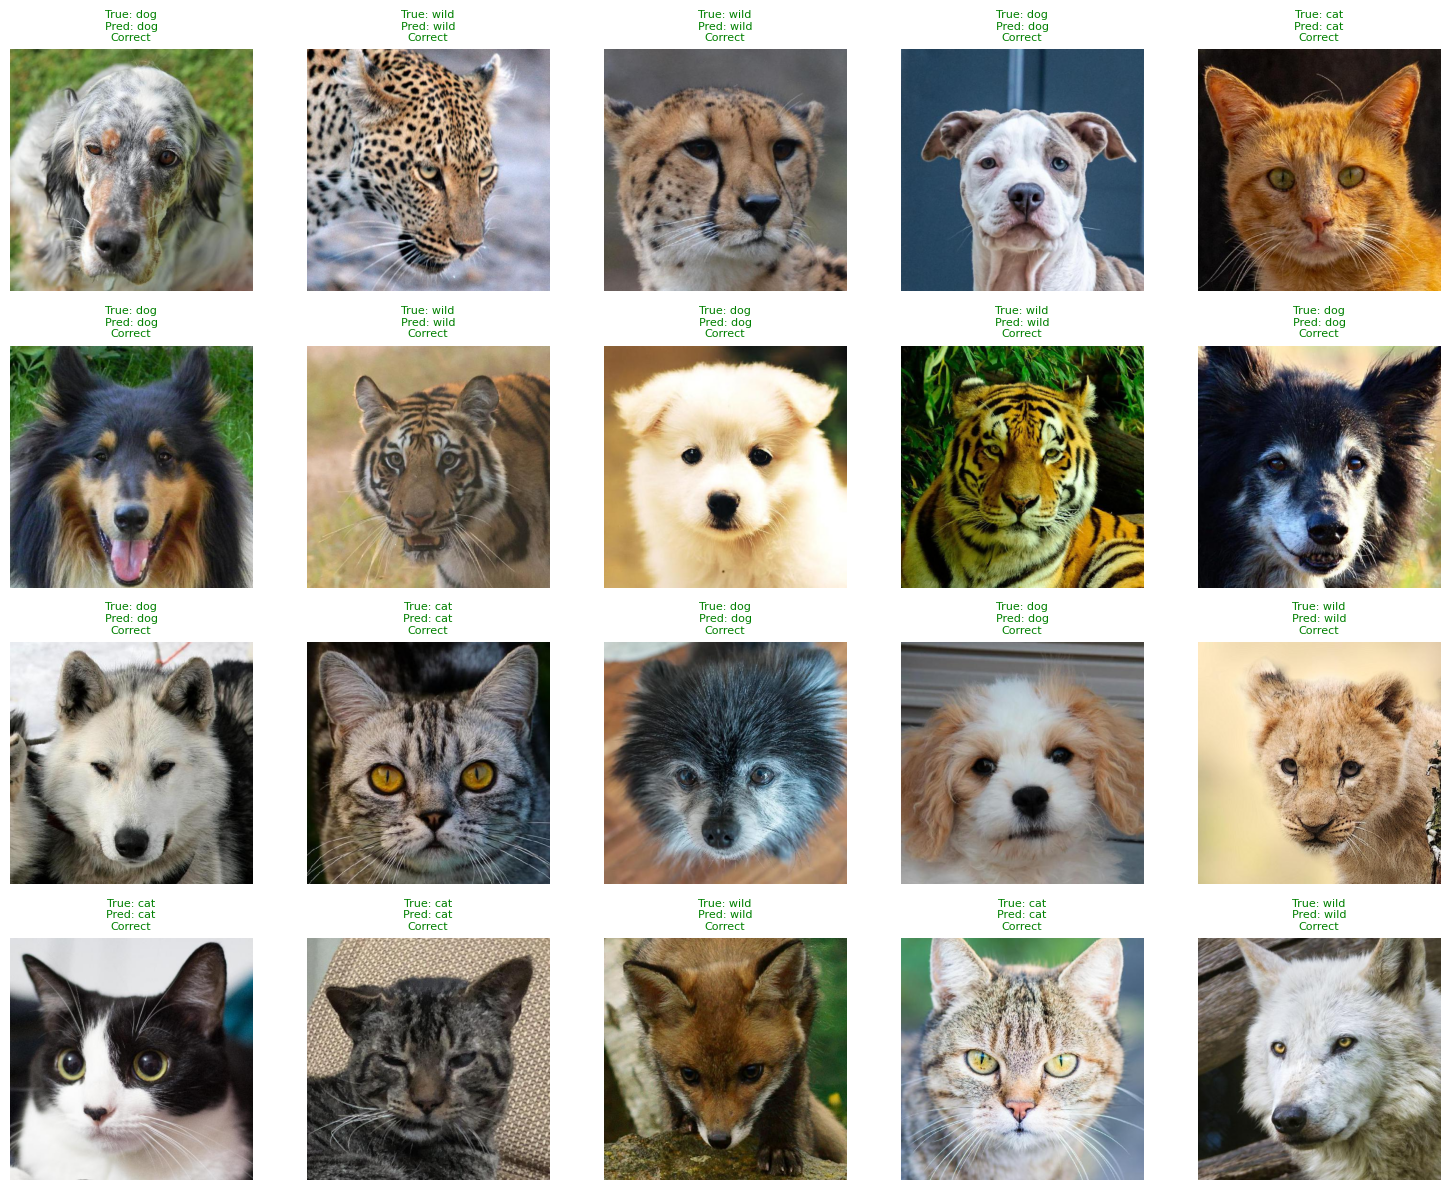

In [26]:
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

num_images = 20
sample_indices = random.sample(range(len(val_dataset)), num_images)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))

for ax, idx in zip(axes.flatten(), sample_indices):
    sample_path, true_label = val_dataset.samples[idx]
    sample_img = Image.open(sample_path)
    
    img_tensor = val_transform(sample_img).unsqueeze(0).to(device)
    
    resnet50.eval()
    with torch.no_grad():
        output = resnet50(img_tensor)
        _, pred = torch.max(output, 1)
    pred_label = pred.item()
    
    result_text = "Correct" if pred_label == true_label else "Incorrect"
    text_color = "green" if pred_label == true_label else "red"
    
    true_label_name = idx_to_class[true_label]
    pred_label_name = idx_to_class[pred_label]
    
    ax.imshow(sample_img)
    ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}\n{result_text}", 
                 fontsize=8, color=text_color)
    ax.axis("off")

plt.tight_layout()
plt.show()